### 0. Pip Install & Load Relevant Libaries

In [ ]:
# To mount Google Drive
from google.colab import drive

# Warnings

import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

# To quickly access files
import os
import glob

# Pandas
import pandas as pd

# import nltk resources
import nltk

resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger","wordnet"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)
        
from nltk.corpus import stopwords, wordnet

# string library
import string

# regex
import re

# wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# ast
import ast

# json
import json

# yaml
import yaml

# time 
import time

# numpy
import numpy as np

# fuzzy matching
try:
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
except:
    !pip install fuzzywuzzy
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process

# math function to check nan values
import math

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# networkx
import networkx as nx

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Mount Drive

In [ ]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Functions

In [ ]:
def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = re.sub(r'www\S+', '', text) # remove www links
    text = re.sub(r'.*\.com', '', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def remove_symbols(text):
    """ Removes all symbols and keep alphanumerics """
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in text if word not in whitelist]

def keep_alphanum(text):
    """ Keep Alphanumeric characters """
    return [word for word in text if word.isalnum()]

def remove_stopwords(text):
    """ Remove Stopwords """
    stop_list = stopwords.words('english')
    stop_list += string.punctuation
    stop_list += [] #any other stop words
    return [word for word in text if word not in stop_list]


def remove_apostrophes(text):
    """ Remove words which have 's with a space """
    return [re.sub(r"'s", "",word) for word in text]

""" Creates a dictionary with slangs and their equivalents and replaces them """
def replaceSlang(text):
    with open('/content/drive/My Drive/FYP/FYP Y4S1/preprocessing_resources/slangs.txt',encoding="ISO-8859-1") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [slang_map[word] if word in slang_map.keys() else word for word in text]

""" Creates a dictionary with contractions and their equivalents and replaces them """
def replaceContraction(text):
    with open('/content/drive/My Drive/FYP/FYP Y4S1/preprocessing_resources/contractions.txt',encoding="ISO-8859-1") as file:
        contraction_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [contraction_map[word] if word in contraction_map.keys() else word for word in text]

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def replaceElongatedText(text):
    return [replaceElongated(word) for word in text]

def remove_multispaces(text):
    """ Replace multiple spaces with only 1 space """
    return [re.sub(r' +', " ",word) for word in text]
    
def normalize_word(text):
    """ Own mapping function """
    replacement_dict = {"l'oreal": 'loreal', "l'oreals":'loreal','b/c': 'because','amazon.com':'amazon',\
                        'cake-y':'cakey', 'build-able':'buildable', 'wal-mart':'walmart', \
                        'q-tip':'cotton swab','l"oreal': 'loreal', 'l"oreals':'loreal',\
                        "a/c":"air conditioning", "co-workers":"colleague", "co-worker":"colleague",\
                        "y'all":"you all"}

    text = [replacement_dict[word] if word in replacement_dict.keys() else word for word in text]

    return text

def lemmatize_words(feedback):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(feedback)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None and word not in stopwords.words('english'):
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word))

    return (lemmatized_sentence)

def clean_text(texts):
    new_texts = [nltk.word_tokenize(str(text)) for text in texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]
    new_texts = [remove_links(text) for text in new_texts]
    new_texts = [removeEmoticons(text) for text in new_texts]
    new_texts = [nltk.word_tokenize(str(text)) for text in new_texts]
    new_texts = [replaceSlang(text) for text in new_texts]
    new_texts = [replaceContraction(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_apostrophes((text)) for text in new_texts]
    new_texts = [replaceElongatedText((text)) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_symbols((text)) for text in new_texts]
    new_texts = [keep_alphanum(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [lemmatize_words(text) for text in new_texts]
    new_texts = [remove_stopwords(text) for text in new_texts]
    new_texts = [remove_multispaces(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]

    return new_texts

## 3. Load Datasets

In [ ]:
%cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/'
final_reviews_df = pd.read_csv('final_reviews.csv',encoding='utf-8')
final_profiles_df = pd.read_csv('final_profiles.csv',encoding='utf-8')
final_reviews_posted_by_profiles_df = pd.read_csv('final_reviews_posted_by_profiles.csv',encoding='utf-8')

print("Size of Reviews Dataset: {}".format(len(final_reviews_df)))
print("Size of Profiles Dataset: {}".format(len(final_profiles_df)))
print("Size of Reviews posted by Profiles Dataset: {}".format(len(final_reviews_posted_by_profiles_df)))

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/final
Size of Reviews Dataset: 85097
Size of Profiles Dataset: 65930
Size of Reviews posted by Profiles Dataset: 544563


## Feature Engineering

### 1. Reviews Posted by Profiles with Reviews

#### 1.1 Label Loreal Reviews Posted by Users

In [ ]:
%cd '/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/'
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/reviews_posted_by_profiles/final_reviews_posted_by_profiles_lorealreviews_feature.csv'):
    final_reviews_posted_by_profiles_df = pd.read_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_lorealreviews_feature.csv',encoding='utf-8')
else:
    loreal_brands = ['loreal', 'garnier' 'maybelline','nyx','shu uemura','lancome', 'giorgio armani', \
                    'armani', 'yvessaintlaurent','kiehls','ralph lauren', 'urban decay', 'it cosmetic', \
                    'kerastase', 'vichy', 'la roche posay', 'skinceuticals']

    start_time = time.time()

    match = list(map(lambda x: process.extractOne(x, loreal_brands, scorer=fuzz.token_set_ratio, \
                                                  processor=lambda x: x),\
                     final_reviews_posted_by_profiles_df['clean_product_name'].astype(str).str.strip()))

    print("Fuzzy Matching Completed! Time taken: %s seconds\n" % (time.time() - start_time))

    match_df = pd.DataFrame(match)
    match_df.columns = ['brand', 'score']

    final_reviews_posted_by_profiles_df['brand_fuzzy_score'] = list(match_df['score'])
    final_reviews_posted_by_profiles_df['Matched_brand'] = list(match_df['brand'])

    final_reviews_posted_by_profiles_df['not_brand_score'] = 102 - final_reviews_posted_by_profiles_df['brand_fuzzy_score']
    final_reviews_posted_by_profiles_df['probability_brand'] = final_reviews_posted_by_profiles_df['brand_fuzzy_score']/final_reviews_posted_by_profiles_df['not_brand_score']
    final_reviews_posted_by_profiles_df.loc[final_reviews_posted_by_profiles_df.probability_brand < 1, "Matched_brand"] = "others"
    final_reviews_posted_by_profiles_df.loc[final_reviews_posted_by_profiles_df.clean_product_name.isnull(), "Matched_brand"] = "others"
    final_reviews_posted_by_profiles_df['loreal_review'] = [0] * len(list(final_reviews_posted_by_profiles_df['clean_product_name']))

    final_reviews_posted_by_profiles_df.loc[final_reviews_posted_by_profiles_df.probability_brand >= 1, "loreal_review"] = 1
    final_reviews_posted_by_profiles_df = final_reviews_posted_by_profiles_df.drop(columns=['not_brand_score'])
    
    final_reviews_posted_by_profiles_df.to_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_lorealreviews_feature.csv',index=False,encoding='utf-8')

display(final_reviews_posted_by_profiles_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/usecase2/feature_engineering


,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,product,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType,status,decoded_comment,clean_product_name,cleaned_text,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,ATVPDKIKX0DER,en_US,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing,NaN,NaN,NaN,0.0,44,others,0.758621,0
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2CTFW6C5WM2O8,R2CTFW6C5WM2O8,1.522119e+12,5.0,public,0.0,Five Stars,Works great! No smudge and comes off easy. It...,en_US,[],True,False,False,productreview,"[{'asin': 'B001IAINFU', 'title': ""L'Oreal Pari...",B001IAINFU,L'Oreal Paris Makeup Double Extend Beauty Tube...,/LOr%C3%A9al-Paris-Makeup-Lengthening-Mascara/...,https://m.media-amazon.com/images/I/31NZIGw5cp...,5343.0,4.5,4.0,True,False,False,PRODUCT,Existing,works great! no smudge and comes off easy. it...,loreal paris makeup double extend beauty tube ...,work great smudge come easy make lashed long d...,17.0,100,loreal,50.000000,1
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2C05U4X4HY5B1,R2C05U4X4HY5B1,1.500857e+12,5.0,public,0.0,Five Stars,I am elderly with very thin and fragil skin an...,en_US,[],True,False,False,productreview,"[{'asin': 'B01DBKRWWY', 'title': 'Quilted Nort...",B01DBKRWWY,"Quilted Northern Ultra Plush Toilet Paper, 12 ...",/Quilted-Northern-Toilet-Double-Regular/dp/B01...,https://m.media-amazon.com/images/I/61jh4+xGlo...,4661.0,4.6,4.0,True,False,False,PRODUCT,Existing,i am elderly with very thin and fragil skin an...,quilted northern ultra plush toilet paper 12 d...,elderly thin fragil skin preferred choice,15.0,21,others,0.259259,0
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.RP51NSSEMHKJK,RP51NSSEMHKJK,1.500857e+12,5.0,public,0.0,A Joy to Read,This book was so enjoyable for me. After suff...,en_US,[],True,False,False,productreview,"[{'asin': 'B00DP64BN8', 'title': 'Nora Roberts...",B00DP64BN8,"Nora Roberts Land (Dare Valley Series, Book 1)",/Nora-Roberts-Land-Dare-Valley-ebook/dp/B00DP6...,https://m.media-amazon.com/images/I/510SzAAOqo...,5969.0,4.3,4.0,True,False,False,PRODUCT,Existing,this book was so enjoyable for me. after suff...,nora robert land dare valley series book 1,book wa enjoyable suffer severe concussion wa ...,159.0,32,others,0.457143,0
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R14B9T2VHFGWH9,R14B9T2VHFGWH9,1.500855e+12,1.0,public,0.0,Do not purchase this model,This opener will not operate on the types of c...,en_US,[],True,False,False,productreview,"[{'asin': 'B06WVBTT2D', 'title': 'Electric Can...",B06WVBTT2D,"Electric Can Opener, Sokos Smooth Soft Edge El...",/Electric-Opener-Smooth-One-Button-Manual/dp/B...,https://m.media-amazon.com/images/I/51dD+PfxnY...,57.0,2.1,2.0,False,False,False,PRODUCT,Existing,this opener will not operate on the types of c...,electric opener sokos smooth soft edge electri...,opener operate type purchase caution wa purcha...,113.0,22,others,0.275000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544558,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,N

#### 1.2 Label Loreal Reviews from Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/reviews/final_reviews_lorealreviews_feature.csv'):
    final_reviews_df = pd.read_csv('reviews/final_reviews_lorealreviews_feature.csv',encoding='utf-8')
else:
    final_reviews_df['Matched_brand'] = "loreal"
    final_reviews_df['probability_brand'] = 1
    final_reviews_df['loreal_review'] = 1
    final_reviews_df.loc[final_reviews_df['Product Category'] == 'Garnier Skincare', "Matched_brand"] = 'garnier'
    final_reviews_df = final_reviews_df.drop(columns=['Product Category','location','date_posted','language',\
                                                    'language_confidence','year','month'])
    
    final_reviews_df.columns = ['asin','clean_title','decoded_comment','rating','verifiedPurchase',\
                                'acc_num','clean_voting','clean_product_name','cleaned_text','word_count',\
                                'Matched_brand','probability_brand','loreal_review']

    final_reviews_df.to_csv('reviews/final_reviews_lorealreviews_feature.csv',index=False,encoding='utf-8')

display(final_reviews_df)

,asin,clean_title,decoded_comment,rating,verifiedPurchase,acc_num,clean_voting,clean_product_name,cleaned_text,word_count,Matched_brand,probability_brand,loreal_review
0,B01M09QQI0,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,face moisturizer l oreal paris skin care age p...,love love love moisturizer woman ha bless many...,101.0,loreal,1,1
1,B01M09QQI0,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,face moisturizer l oreal paris skin care age p...,moisturizer work well skin let start say 37 ye...,142.0,loreal,1,1
2,B01M09QQI0,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,face moisturizer l oreal paris skin care age p...,know sound good true maybe folk try nice wa te...,78.0,loreal,1,1
3,B01M09QQI0,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,face moisturizer l oreal paris skin care age p...,first jar order smell wonderful go skin smooth...,76.0,loreal,1,1
4,B01M09QQI0,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,face moisturizer l oreal paris skin care age p...,use product six week 62 daily moisturizer ha m...,131.0,loreal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,B0047ENUXE,NaN,everlasting plum is my favorite shade. very pi...,0.8,1.0,NaN,0,paris infallible le rouge lipstick always apri...,everlasting plum favorite shade pigmented matt...,37.0,loreal,1,1
85093,B0047ENUXE,NaN,i got this for 564 i mean this is a steal for ...,1.0,1.0,NaN,1,paris infallible le rouge lipstick always apri...,get 564 mean steal price rambling rise beautif...,40.0,loreal,1,1
85094,B0047ENUXE,NaN,i love the color absolutely. it brightens up t...,0.8,1.0,NaN,0,paris infallible le rouge lipstick always apri...,love color absolutely brighten face immediatel...,151.0,loreal,1,1
85095,B0047ENUXE,NaN,very nice shade to give you pink lips..quality...,1.0,1.0,NaN,0,paris infallible le rouge lipstick always apri...,nice shade give pink lipstick shine moisture g...,28.0,loreal,1,1


#### 1.3 Check both dataframe for missing data before merging

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/reviews_posted_by_profiles/final_reviews_posted_by_profiles_filteredclean.csv'):
    final_reviews_posted_by_profiles_df = pd.read_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_filteredclean.csv',encoding='utf-8')
else:
    final_reviews_posted_by_profiles_df = final_reviews_posted_by_profiles_df[['acc_num','name','sortTimestamp','rating',\
                                                                           'helpfulVotes','verifiedPurchase','asin',\
                                                                           'status','reviewCount','decoded_comment',\
                                                                           'cleaned_text','clean_product_name','word_count',\
                                                                           'brand_fuzzy_score','Matched_brand',\
                                                                           'probability_brand','loreal_review',\
                                                                           'verifiedPurchase']]
    final_reviews_posted_by_profiles_df['rating'] = final_reviews_posted_by_profiles_df['rating'].fillna(value=0)
    final_reviews_posted_by_profiles_df['helpfulVotes'] = final_reviews_posted_by_profiles_df['helpfulVotes'].fillna(value=0)
    final_reviews_posted_by_profiles_df['reviewCount'] = final_reviews_posted_by_profiles_df['reviewCount'].fillna(value=0)
    final_reviews_posted_by_profiles_df['decoded_comment'] = final_reviews_posted_by_profiles_df['decoded_comment'].fillna(value="")
    final_reviews_posted_by_profiles_df['cleaned_text'] = final_reviews_posted_by_profiles_df['cleaned_text'].fillna(value="")
    final_reviews_posted_by_profiles_df['clean_product_name'] = final_reviews_posted_by_profiles_df['clean_product_name'].fillna(value="")
    final_reviews_posted_by_profiles_df['word_count'] = final_reviews_posted_by_profiles_df['word_count'].fillna(value=0)

    clean_verified = []
    for index, row in final_reviews_posted_by_profiles_df.iterrows():
        if row['verifiedPurchase'].any():
            clean_verified.append(1)
        else:
            clean_verified.append(0)

    final_reviews_posted_by_profiles_df = final_reviews_posted_by_profiles_df.drop(columns=['verifiedPurchase'])

    final_reviews_posted_by_profiles_df['verifiedPurchase'] = clean_verified
    final_reviews_posted_by_profiles_df = final_reviews_posted_by_profiles_df.rename(columns={'verifiedPurchase.1':'verifiedPurchase'})

    final_reviews_posted_by_profiles_df.to_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_filteredclean.csv',index=False,encoding='utf-8')

print(final_reviews_posted_by_profiles_df.info())
display(final_reviews_posted_by_profiles_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544563 entries, 0 to 544562
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   acc_num             544563 non-null  object 
 1   name                544485 non-null  object 
 2   sortTimestamp       540016 non-null  float64
 3   rating              544563 non-null  float64
 4   helpfulVotes        544563 non-null  float64
 5   asin                540016 non-null  object 
 6   status              544563 non-null  object 
 7   reviewCount         544563 non-null  float64
 8   decoded_comment     539443 non-null  object 
 9   cleaned_text        538892 non-null  object 
 10  clean_product_name  519906 non-null  object 
 11  word_count          544563 non-null  float64
 12  brand_fuzzy_score   544563 non-null  int64  
 13  Matched_brand       544563 non-null  object 
 14  probability_brand   544563 non-null  float64
 15  loreal_review       544563 non-nul

,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,0.0,0.0,NaN,Existing,0.0,NaN,NaN,NaN,0.0,44,others,0.758621,0,0
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,1.522119e+12,5.0,0.0,B001IAINFU,Existing,5343.0,works great! no smudge and comes off easy. it...,work great smudge come easy make lashed long d...,loreal paris makeup double extend beauty tube ...,17.0,100,loreal,50.000000,1,1
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,5.0,0.0,B01DBKRWWY,Existing,4661.0,i am elderly with very thin and fragil skin an...,elderly thin fragil skin preferred choice,quilted northern ultra plush toilet paper 12 d...,15.0,21,others,0.259259,0,1
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,5.0,0.0,B00DP64BN8,Existing,5969.0,this book was so enjoyable for me. after suff...,book wa enjoyable suffer severe concussion wa ...,nora robert land dare valley series book 1,159.0,32,others,0.457143,0,1
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500855e+12,1.0,0.0,B06WVBTT2D,Existing,57.0,this opener will not operate on the types of c...,opener operate type purchase caution wa purcha...,electric opener sokos smooth soft edge electri...,113.0,22,others,0.275000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544558,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,0.0,0.0,NaN,Deleted,0.0,none,none,NaN,1.0,44,others,0.758621,0,0
544559,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,0.0,0.0,NaN,Deleted,0.0,none,none,NaN,1.0,44,others,0.758621,0,0
544560,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,0.0,0.0,NaN,Deleted,0.0,none,none,NaN,1.0,44,others,0.758621,0,0
544561,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,0.0,0.0,NaN,Deleted,0.0,none,none,NaN,1.0,44,others,0.758621,0,0


In [ ]:
print(final_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85097 entries, 0 to 85096
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asin                85097 non-null  object 
 1   clean_title         77307 non-null  object 
 2   decoded_comment     85096 non-null  object 
 3   rating              85097 non-null  float64
 4   verifiedPurchase    72871 non-null  float64
 5   acc_num             77320 non-null  object 
 6   clean_voting        85097 non-null  int64  
 7   clean_product_name  85097 non-null  object 
 8   cleaned_text        85002 non-null  object 
 9   word_count          85097 non-null  float64
 10  Matched_brand       85097 non-null  object 
 11  probability_brand   85097 non-null  int64  
 12  loreal_review       85097 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 8.4+ MB
None


In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/merged_reviews/merged_reviews.csv'):
    merged_reviews_df = pd.read_csv('merged_reviews/merged_reviews.csv',encoding='utf-8')
else:
    missing_columns1 = [column for column in final_reviews_posted_by_profiles_df.columns if column not in final_reviews_df.columns]
    missing_columns2 = [column for column in final_reviews_df.columns if column not in final_reviews_posted_by_profiles_df.columns]

    print('Currently Missing Columns in Reviews Posted By Profiles Dataset: {}'.format(missing_columns1))
    print('Currently Missing Columns in Reviews Dataset: {}\n'.format(missing_columns2))

    for column in missing_columns1:
        final_reviews_df[column] = np.nan

    for column in missing_columns2:
        final_reviews_posted_by_profiles_df[column] = np.nan

    missing_columns1 = [column for column in final_reviews_posted_by_profiles_df.columns if column not in final_reviews_df.columns]
    missing_columns2 = [column for column in final_reviews_df.columns if column not in final_reviews_posted_by_profiles_df.columns]

    print('Currently Missing Columns in Reviews Posted By Profiles Dataset: {}'.format(missing_columns1))
    print('Currently Missing Columns in Reviews Dataset: {}\n'.format(missing_columns2))

    final_reviews_df = final_reviews_df[final_reviews_posted_by_profiles_df.columns]

    print('Current Column Order in Reviews Posted By Profiles Dataset: {}'.format(final_reviews_posted_by_profiles_df.columns.tolist()))
    print('Current Column Order in Reviews Dataset: {}\n'.format(final_reviews_df.columns.tolist()))

    print('Current Size of Reviews Posted By Profiles Dataset: {}'.format(len(final_reviews_posted_by_profiles_df.columns.tolist())))
    print('Current Size of Reviews Dataset: {}\n'.format(len(final_reviews_df.columns.tolist())))

    final_reviews_posted_by_profiles_df['dataset'] = 'profile_reviews'
    final_reviews_df['dataset'] = 'reviews'

    merged_reviews_df = final_reviews_posted_by_profiles_df.append(final_reviews_df)
    print("Size of New Merged Dataset: {}".format(len(merged_reviews_df)))

    merged_reviews_df = merged_reviews_df.drop_duplicates(subset=['acc_num','asin','decoded_comment'], keep="first")
    print("Size of New Merged Dataset After Dropping Duplicates: {}\n".format(len(merged_reviews_df)))
    
    merged_reviews_df.to_csv('merged_reviews/merged_reviews.csv',index=False,encoding='utf-8')

display(merged_reviews_df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase,clean_title,clean_voting,dataset
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,0.0,0.0,NaN,Existing,0.0,NaN,NaN,NaN,0.0,44.0,others,0.758621,0,0.0,NaN,NaN,profile_reviews
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,1.522119e+12,5.0,0.0,B001IAINFU,Existing,5343.0,works great! no smudge and comes off easy. it...,work great smudge come easy make lashed long d...,loreal paris makeup double extend beauty tube ...,17.0,100.0,loreal,50.000000,1,1.0,NaN,NaN,profile_reviews
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,5.0,0.0,B01DBKRWWY,Existing,4661.0,i am elderly with very thin and fragil skin an...,elderly thin fragil skin preferred choice,quilted northern ultra plush toilet paper 12 d...,15.0,21.0,others,0.259259,0,1.0,NaN,NaN,profile_reviews
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,5.0,0.0,B00DP64BN8,Existing,5969.0,this book was so enjoyable for me. after suff...,book wa enjoyable suffer severe concussion wa ...,nora robert land dare valley series book 1,159.0,32.0,others,0.457143,0,1.0,NaN,NaN,profile_reviews
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500855e+12,1.0,0.0,B06WVBTT2D,Existing,57.0,this opener will not operate on the types of c...,opener operate type purchase caution wa purcha...,electric opener sokos smooth soft edge electri...,113.0,22.0,others,0.275000,0,1.0,NaN,NaN,profile_reviews
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616268,NaN,NaN,NaN,0.8,NaN,B0047ENUXE,NaN,NaN,everlasting plum is my favorite shade. very pi...,everlasting plum favorite shade pigmented matt...,paris infallible le rouge lipstick always apri...,37.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews
616269,NaN,NaN,NaN,1.0,NaN,B0047ENUXE,NaN,NaN,i got this for 564 i mean this is a steal for ...,get 564 mean steal price rambling rise beautif...,paris infallible le rouge lipstick always apri...,40.0,NaN,loreal,1.000000,1,1.0,NaN,1.0,reviews
616270,NaN,NaN,NaN,0.8,NaN,B0047ENUXE,NaN,NaN,i love the color absolutely. it brightens up t...,love color absolutely brighten face immediatel...,paris infallible le rouge lipstick always apri...,151.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews
616271,NaN,NaN,NaN,1.0,NaN,B0047ENUXE,NaN,NaN,very nice shade to give you pink lips..quality...,nice shade give pink lipstick shine moisture g...,paris infallible le rouge lipstick always apri...,28.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews


,loreal_review,count
0,0,513169
1,1,103104


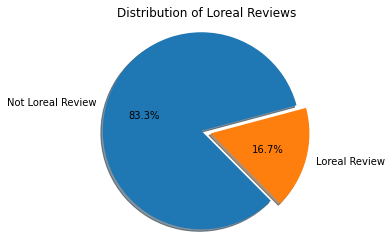

In [ ]:
loreal_reviews_df = merged_reviews_df.groupby('loreal_review').size().reset_index(name='count')
display(loreal_reviews_df)

my_explode = (0, 0.1)
plt.pie(list(loreal_reviews_df['count']),labels=['Not Loreal Review','Loreal Review'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of Loreal Reviews')
plt.axis('equal')
plt.show()

#### 1.4 Sample Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/merged_reviews/merged_reviews_samplereviews_feature.csv'):
    merged_reviews_df = pd.read_csv('merged_reviews/merged_reviews_samplereviews_feature.csv',encoding='utf-8')
else:
    reviews = list(merged_reviews_df['cleaned_text'])
    new_reviews = []
    for review in reviews:
        try:
            null_review = float(review)
            if math.isnan(null_review):
                new_reviews.append("")
            else:
                new_reviews.append(review)
        except:
            new_reviews.append(review)
            
    sample_reviews = [1 if 'sample' in review else 0 for review in new_reviews]
    merged_reviews_df['sample_review'] = sample_reviews

    merged_reviews_df.to_csv('merged_reviews/merged_reviews_samplereviews_feature.csv',index=False,encoding='utf-8')

display(merged_reviews_df[merged_reviews_df['sample_review'] == 1])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase,clean_title,clean_voting,dataset,sample_review
39,AEALC7TFM2T5OZ6XA7TQ7M6KX5XA,Encie,1.588701e+12,5.0,0.0,B07H38SRNW,Existing,177.0,we were hosting a booth at discovery days and ...,host booth discovery day make fresh salsa bicy...,compostable luncheon eco friendly natural baga...,105.0,21.0,others,0.259259,0,1.0,NaN,NaN,profile_reviews,1
356,AHS5VCIPFIS4XDYTXYX3H6NFZERA,maggiepaul,1.589494e+12,1.0,0.0,B074PVGQQB,Existing,2577.0,definitely not what i wanted. i really liked t...,definitely want really like infallible pencil ...,loreal paris cosmetic infallible waterproof pe...,50.0,100.0,loreal,50.000000,1,1.0,NaN,NaN,profile_reviews,1
888,AEMP3A7IKW37CMWFXNKXWW6HGJHA,OneWhisper,1.601814e+12,5.0,0.0,B0751BN57M,Existing,5.0,the toner comes in a large bottle that comes i...,toner come large bottle come box get product p...,hyaluronic acid essence toner oxygenceuticals ...,539.0,17.0,others,0.200000,0,0.0,NaN,NaN,profile_reviews,1
3064,AFCXSFZRRN5PI4FDWE4W3AGWPALQ,Cassandra Card,1.430329e+12,1.0,1.0,B00L9OVCQW,Existing,561.0,i have been using 1/4 drams for essential oils...,use dram essential oil sample year never buy 2...,dram amber glass vial screw cap orifice reduce...,53.0,23.0,others,0.291139,0,1.0,NaN,NaN,profile_reviews,1
3925,AFQWEPYUK7QAQ4PVR3KEYOXMSYDQ,Matthew D Wion,1.078179e+12,4.0,6.0,B000006US5,Existing,28.0,frist of all this album shows you just how ver...,frist album show versatile brightman versatili...,come age,229.0,67.0,lancome,1.914286,1,0.0,NaN,NaN,profile_reviews,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614265,AFZNJJ5VXXHTZUSEBF64EJCXGC6A,NaN,NaN,0.8,NaN,B07Z9WFWZ8,NaN,NaN,"overall, i really like this foundation. i'm 4...",overall really like foundation 49 year old mil...,loreal paris age perfect radiant serum foundat...,215.0,NaN,loreal,1.000000,1,1.0,"holds up nicely but beware the ""golden"" tones",4.0,reviews,1
614280,AE5EMAHTS63NPZ5SRRNV5WCSJHGA,NaN,NaN,0.8,NaN,B07Z9WFWZ8,NaN,NaN,"i've been wanting to try one of the new ""serum...",want try one new serum foundation like ostensi...,loreal paris age perfect radiant serum foundat...,157.0,NaN,loreal,1.000000,1,NaN,"lightweight, spf 50, smooth on moisturizing fo...",1.0,reviews,1
614290,AH2UPH4DYTWNNO7BMH5ASOVQYIWQ,NaN,NaN,0.8,NaN,B07Z9WFWZ8,NaN,NaN,i received the color of 125 cappuccino. normal...,receive color 125 cappuccino normally brand we...,loreal paris age perfect radiant serum foundat...,188.0,NaN,loreal,1.000000,1,NaN,very hydrating and great coverage,2.0,reviews,1
615008,AFANGLEBUU4ZAR2V22KG72RXFHQA,NaN,NaN,0.2,NaN,B07YGB5SPC,NaN,NaN,i rarely write a review but i had to on this o...,rarely write review one seem rave year worth u...,hyaluronic acid serum skin loreal paris skinca...,145.0,NaN,loreal,1.000000,1,NaN,"read this before you purchase, don't waste you...",2.0,reviews,1


,sample_review,count
0,0,615293
1,1,980


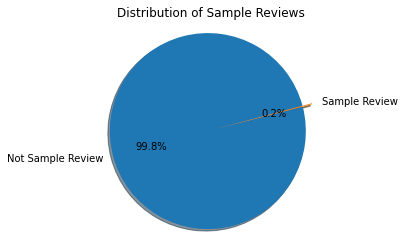

In [ ]:
sample_reviews_df = merged_reviews_df.groupby('sample_review').size().reset_index(name='count')
display(sample_reviews_df)

my_explode = (0, 0.1)
plt.pie(list(sample_reviews_df['count']),labels=['Not Sample Review','Sample Review'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of Sample Reviews')
plt.axis('equal')
plt.show()

#### 1.5 Incentivized Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/merged_reviews/merged_reviews_incentivizedreviews_feature.csv'):
    merged_reviews_df = pd.read_csv('merged_reviews/merged_reviews_incentivizedreviews_feature.csv',encoding='utf-8')
else:
    incentivized_texts = ['I have received this product for a discount in exchange for my honest review.',\
                          'This product was received at no cost for review and inspection purposes.',\
                          'Just received and am completing to receive a free bottle. WIll follow up after first month.']
                          
    clean_incentivized_text = clean_text(incentivized_texts)

    start_time = time.time()

    match = list(map(lambda x: process.extractOne(x, clean_incentivized_text, scorer=fuzz.token_set_ratio, \
                                                    processor=lambda x: x),\
                        merged_reviews_df['cleaned_text'].astype(str).str.strip()))

    print("Fuzzy Matching Completed! Time taken: %s seconds\n" % (time.time() - start_time))

    match_df = pd.DataFrame(match)
    match_df.columns = ['incentivized_text', 'score']

    merged_reviews_df['incentivized_text_score'] = list(match_df['score'])
    merged_reviews_df['incentivized_text'] = list(match_df['incentivized_text'])

    merged_reviews_df['not_incentivized_texts_score'] = 102 - merged_reviews_df['incentivized_text_score']
    merged_reviews_df['probability_incentivized_text'] = merged_reviews_df['incentivized_text_score']/merged_reviews_df['not_incentivized_texts_score']
    merged_reviews_df.loc[merged_reviews_df.probability_incentivized_text < 1, "incentivized_text"] = np.nan
    merged_reviews_df.loc[merged_reviews_df.decoded_comment.isnull(), "incentivized_text"] = np.nan

    merged_reviews_df['incentivized_review'] = [0] * len(list(merged_reviews_df['cleaned_text']))

    merged_reviews_df.loc[merged_reviews_df.probability_incentivized_text >= 1, "incentivized_review"] = 1

    merged_reviews_df.to_csv('merged_reviews/merged_reviews_incentivizedreviews_feature.csv',index=False,encoding='utf-8')

display(merged_reviews_df[merged_reviews_df['incentivized_review'] == 1])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase,clean_title,clean_voting,dataset,sample_review,incentivized_text_score,incentivized_text,not_incentivized_texts_score,probability_incentivized_text,incentivized_review
128,AEYU3RBGXSEIFKMCHYHPYUKN6VCA,roberta,1.584707e+12,5.0,0.0,B01GFLZ4DU,Existing,6212.0,great product,great product,windex glass window cleaner spray bottle bottl...,2.0,18.0,others,0.214286,0,1.0,NaN,NaN,profile_reviews,0,70,I receive product discount exchange honest review,32,2.187500,1
179,AHHJOKAG2TWSLW6UKW5NIJJ2TXBA,Amazon Customer,1.573525e+12,5.0,0.0,B00XNR174A,Existing,47.0,love these bottles.,love bottle,4 pack roll empty glass bottle essential oil r...,3.0,19.0,others,0.228916,0,1.0,NaN,NaN,profile_reviews,0,71,Just receive complete receive free bottle WIll...,31,2.290323,1
197,AF7JFMT6WCQBFEFVYTFKUW2W5FEQ,Kelly,1.601511e+12,5.0,0.0,B07WTJXMN6,Existing,1434.0,easy to install. register product and you get ...,easy install register product get insurance re...,zag invisibleshield screen protector temper gl...,17.0,16.0,others,0.186047,0,1.0,NaN,NaN,profile_reviews,0,54,This product wa receive cost review inspection...,48,1.125000,1
209,AEWC4SNRX7P6FK7QFHKQ4Y7XLSVA,Yvonne,1.583567e+12,5.0,0.0,B00B4YVU4G,Existing,34136.0,this product works great!,product work great,nyx professional makeup makeup set spray matte...,4.0,100.0,nyx,50.000000,1,1.0,NaN,NaN,profile_reviews,0,56,I receive product discount exchange honest review,46,1.217391,1
213,AEWC4SNRX7P6FK7QFHKQ4Y7XLSVA,Yvonne,1.583566e+12,5.0,0.0,B00BR3VPLC,Existing,5081.0,this product works great!,product work great,touch sol pore blem primer 30ml 1 pack face ma...,4.0,20.0,others,0.243902,0,1.0,NaN,NaN,profile_reviews,0,56,I receive product discount exchange honest review,46,1.217391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616206,NaN,NaN,NaN,0.2,NaN,B0047ENUXE,NaN,NaN,product damage,product damage,paris infallible le rouge lipstick always apri...,2.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,67,I receive product discount exchange honest review,35,1.914286,1
616216,AFYMVLVWG7VXQMPOUIKJWPOKTC2Q,NaN,NaN,0.8,NaN,B0047ENUXE,NaN,NaN,decent product for the price,decent product price,paris infallible le rouge lipstick always apri...,5.0,NaN,loreal,1.000000,1,NaN,decent product for the price,0.0,reviews,0,52,I receive product discount exchange honest review,50,1.040000,1
616240,NaN,NaN,NaN,0.2,NaN,B0047ENUXE,NaN,NaN,the product i received seemed old. lipstick wa...,product receive seem old lipstick wa sticky un...,paris infallible le rouge lipstick always apri...,15.0,NaN,loreal,1.000000,1,1.0,NaN,6.0,reviews,0,57,This product wa receive cost review inspection...,45,1.266667,1
616259,NaN,NaN,NaN,0.2,NaN,B0047ENUXE,NaN,NaN,got a used product,get used product,paris infallible le rouge lipstick always apri...,4.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,61,I receive product discount exchange honest review,41,1.487805,1


,incentivized_review,count
0,0,605618
1,1,10655


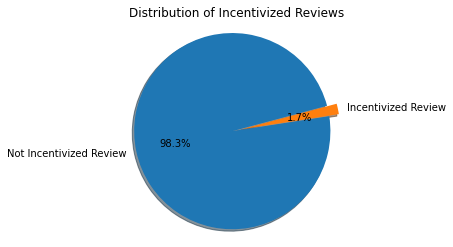

In [ ]:
incentivized_reviews_df = merged_reviews_df.groupby('incentivized_review').size().reset_index(name='count')
display(incentivized_reviews_df)

my_explode = (0, 0.1)
plt.pie(list(incentivized_reviews_df['count']),labels=['Not Incentivized Review','Incentivized Review'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of Incentivized Reviews')
plt.axis('equal')
plt.show()

### 2. Profiles

#### 2.1 Reviewer Ease

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_reviewerease_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_reviewerease_feature.csv',encoding='utf-8')
else:
    merged_reviews_df.loc[merged_reviews_df['dataset'] == 'profile_reviews', "rating"] /= max(merged_reviews_df[merged_reviews_df['dataset'] == 'profile_reviews']['rating'])
    merged_reviews_df[merged_reviews_df['dataset'] == 'profile_reviews']['rating']
    merged_reviews_df['rating'] = merged_reviews_df['rating'].fillna(value=0)
    
    reviewer_ease_df = merged_reviews_df.groupby('acc_num').agg({'rating':np.mean}).reset_index()
    reviewer_ease_df = reviewer_ease_df.rename(columns={'rating':'reviewer_ease_score'})

    final_profiles_df = pd.merge(final_profiles_df,reviewer_ease_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df['reviewer_ease_score'] = final_profiles_df['reviewer_ease_score'].fillna(value=0)

    final_profiles_df.to_csv('profiles/final_profiles_reviewerease_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviews_posted,reviewer_ease_score
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.400000
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.0,1.000000
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,10.0,0.854545
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,10.0,0.727273
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,10.0,0.981818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.400000
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.333333


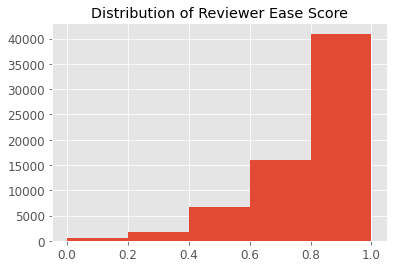

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(final_profiles_df['reviewer_ease_score'], bins=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Reviewer Ease Score")
plt.show()

#### 2.2 Brand Repeats

In [ ]:
loreal_products_reviews_df = merged_reviews_df[merged_reviews_df['Matched_brand'] != 'others'].groupby(['acc_num','Matched_brand']).size().reset_index(name='count')
loreal_products_reviews_df = loreal_products_reviews_df.groupby('acc_num').size().reset_index(name='total_loreal_products')

total_products_reviews_df = merged_reviews_df.groupby(['acc_num','Matched_brand']).size().reset_index(name='count')
total_products_reviews_df = total_products_reviews_df.groupby('acc_num').size().reset_index(name='total_products')

brand_products_reviews_df = pd.merge(total_products_reviews_df,loreal_products_reviews_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
brand_products_reviews_df['total_loreal_products'] = brand_products_reviews_df['total_loreal_products'].fillna(value=0)

print(brand_products_reviews_df.info())
display(brand_products_reviews_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65929 entries, 0 to 65928
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   acc_num                65929 non-null  object 
 1   total_products         65929 non-null  int64  
 2   total_loreal_products  65929 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ MB
None


,acc_num,total_products,total_loreal_products
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,2,1.0
1,AE22JJYZQC6KT354WG4JSJCU4WXA,2,1.0
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,2,1.0
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,2,1.0
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,2,1.0
...,...,...,...
65924,AHZZONVVQ454QUCD23HMD5E7VNIQ,2,1.0
65925,AHZZTMJPOUBTHE3KC3NONEWETDAA,2,1.0
65926,AHZZVMDHFFSBOVISWYOV7RX7XBTA,3,2.0
65927,comnan,1,0.0


In [ ]:
loreal_reviews_df = merged_reviews_df[merged_reviews_df['Matched_brand'] != 'others'].groupby(['acc_num','Matched_brand']).agg({'loreal_review':np.sum}).reset_index()
loreal_reviews_df = loreal_reviews_df.groupby(['acc_num']).agg({'loreal_review':np.sum}).reset_index()
loreal_reviews_df = loreal_reviews_df.rename(columns={'loreal_review':'total_loreal_reviews'})
display(loreal_reviews_df)

,acc_num,total_loreal_reviews
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,2
1,AE22JJYZQC6KT354WG4JSJCU4WXA,1
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,1
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,1
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,1
...,...,...
61682,AHZZCA3IUYD3WHWOFHECMLPNJZLQ,1
61683,AHZZJOVR5WVI2PCSST3A6JQN57SA,1
61684,AHZZONVVQ454QUCD23HMD5E7VNIQ,1
61685,AHZZTMJPOUBTHE3KC3NONEWETDAA,1


In [ ]:
final_profiles_df = pd.merge(final_profiles_df,loreal_reviews_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
final_profiles_df['total_loreal_reviews'] = final_profiles_df['total_loreal_reviews'].fillna(value=0)
final_profiles_df['reviews_posted'] = final_profiles_df['reviews_posted'].fillna(value=0)

final_profiles_df['proportion_loreal_reviews'] = final_profiles_df['total_loreal_reviews'] / final_profiles_df['reviews_posted']

final_profiles_df = pd.merge(final_profiles_df,brand_products_reviews_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
final_profiles_df['proportion_brand_products'] = final_profiles_df['total_loreal_products'] / final_profiles_df['total_products']

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviews_posted,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.0,1.000000,2.0,2.0,1.0,1.0,1.000000
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,10.0,0.854545,1.0,0.1,2.0,1.0,0.500000
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,10.0,0.727273,2.0,0.2,2.0,1.0,0.500000
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,10.0,0.981818,2.0,0.2,3.0,2.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000







1.  Brand Repeaters have reviewed more than one product by this brand.
2.  Brand Loyalists have written multiple reviews, of which 50% or more are for this brand.
3.  Brand Monogamists have reviewed multiple products but all of them are for this brand.



In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_brandrepeats_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_brandrepeats_feature.csv',encoding='utf-8')
else:
    brand_repeat_class = []
    for index,row in final_profiles_df.iterrows():
        if row['total_loreal_products'] > 1 and row['proportion_brand_products'] == 1 and row['proportion_loreal_reviews'] == 1:
            brand_repeat_class.append('Brand Monogamist')
        elif row['reviews_posted'] > 1 and row['proportion_brand_products'] >= 0.5:
            brand_repeat_class.append('Brand Loyalist')
        elif row['total_loreal_products'] == 1:
            brand_repeat_class.append('Brand Repeater')
        else:
            brand_repeat_class.append('Others')

    final_profiles_df['brand_repeat_class'] = brand_repeat_class

    final_profiles_df.to_csv('profiles/final_profiles_brandrepeats_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviews_posted,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,10.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,10.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,10.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater


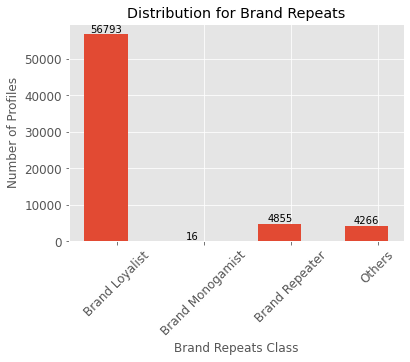

In [ ]:
brand_repeats_df = final_profiles_df.groupby('brand_repeat_class').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, len(brand_repeats_df['brand_repeat_class']) + 1)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, brand_repeats_df['count'], width=bar_width)
ax.set_ylabel("Number of Profiles", fontsize=12)
ax.set_xlabel("Brand Repeats Class", fontsize=12)
plt.xticks(xtick_pos, brand_repeats_df['brand_repeat_class'],rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution for Brand Repeats")

rects = ax.patches

# Make some labels.
labels = list(brand_repeats_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 2.3 Total Reviews Posted

In [ ]:
total_reviews_df = merged_reviews_df.groupby('acc_num').size().reset_index(name='reviews_posted')
final_profiles_df = final_profiles_df.drop(columns=['reviews_posted'])
final_profiles_df = pd.merge(final_profiles_df,total_reviews_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class,reviews_posted
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater,2.0
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist,11.0
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist,11.0
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater,3.0


#### 2.4 Suspicious Reviewer

##### 2.4.1 Check for Deleted Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/merged_reviews/merged_reviews_deletedreviews_feature.csv'):
    merged_reviews_df = pd.read_csv('merged_reviews/merged_reviews_deletedreviews_feature.csv',encoding='utf-8')
else:
    deleted_reviews = [0] * len(merged_reviews_df)
    for index,row in merged_reviews_df.iterrows():
        review = row['decoded_comment']
        null_review = False
        try:
            null_review = float(review)
            if math.isnan(null_review):
                null_review = True
        except:
            continue
        if row['status'] == 'Deleted':
            deleted_reviews[index] = 1
        elif null_review and row['status'] == 'Existing':
            deleted_reviews[index] = 1

    merged_reviews_df['deleted_review'] = deleted_reviews

    merged_reviews_df.to_csv('merged_reviews/merged_reviews_deletedreviews_feature.csv',index=False,encoding='utf-8')

display(merged_reviews_df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase,clean_title,clean_voting,dataset,sample_review,incentivized_text_score,incentivized_text,not_incentivized_texts_score,probability_incentivized_text,incentivized_review,deleted_review
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,0.0,0.0,NaN,Existing,0.0,NaN,NaN,NaN,0.0,44.0,others,0.758621,0,0.0,NaN,NaN,profile_reviews,0,12,NaN,90,0.133333,0,1
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,1.522119e+12,1.0,0.0,B001IAINFU,Existing,5343.0,works great! no smudge and comes off easy. it...,work great smudge come easy make lashed long d...,loreal paris makeup double extend beauty tube ...,17.0,100.0,loreal,50.000000,1,1.0,NaN,NaN,profile_reviews,0,31,NaN,71,0.436620,0,0
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,1.0,0.0,B01DBKRWWY,Existing,4661.0,i am elderly with very thin and fragil skin an...,elderly thin fragil skin preferred choice,quilted northern ultra plush toilet paper 12 d...,15.0,21.0,others,0.259259,0,1.0,NaN,NaN,profile_reviews,0,36,NaN,66,0.545455,0,0
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500857e+12,1.0,0.0,B00DP64BN8,Existing,5969.0,this book was so enjoyable for me. after suff...,book wa enjoyable suffer severe concussion wa ...,nora robert land dare valley series book 1,159.0,32.0,others,0.457143,0,1.0,NaN,NaN,profile_reviews,0,15,NaN,87,0.172414,0,0
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,1.500855e+12,0.2,0.0,B06WVBTT2D,Existing,57.0,this opener will not operate on the types of c...,opener operate type purchase caution wa purcha...,electric opener sokos smooth soft edge electri...,113.0,22.0,others,0.275000,0,1.0,NaN,NaN,profile_reviews,0,22,NaN,80,0.275000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616268,NaN,NaN,NaN,0.8,NaN,B0047ENUXE,NaN,NaN,everlasting plum is my favorite shade. very pi...,everlasting plum favorite shade pigmented matt...,paris infallible le rouge lipstick always apri...,37.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,30,NaN,72,0.416667,0,0
616269,NaN,NaN,NaN,1.0,NaN,B0047ENUXE,NaN,NaN,i got this for 564 i mean this is a steal for ...,get 564 mean steal price rambling rise beautif...,paris infallible le rouge lipstick always apri...,40.0,NaN,loreal,1.000000,1,1.0,NaN,1.0,reviews,0,35,NaN,67,0.522388,0,0
616270,NaN,NaN,NaN,0.8,NaN,B0047ENUXE,NaN,NaN,i love the color absolutely. it brightens up t...,love color absolutely brighten face immediatel...,paris infallible le rouge lipstick always apri...,151.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,31,NaN,71,0.436620,0,0
616271,NaN,NaN,NaN,1.0,NaN,B0047ENUXE,NaN,NaN,very nice shade to give you pink lips..quality...,nice shade give pink lipstick shine moisture g...,paris infallible le rouge lipstick always apri...,28.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,21,NaN,81,0.259259,0,0


##### 2.4.2 Check total deleted reviews by profiles

In [ ]:
total_deleted_reviews_df = merged_reviews_df.groupby(['acc_num']).agg({'deleted_review':np.sum}).reset_index()
total_deleted_reviews_df = total_deleted_reviews_df.rename(columns={'deleted_review':'total_deleted_reviews'})
display(total_deleted_reviews_df)

,acc_num,total_deleted_reviews
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,0
1,AE22JJYZQC6KT354WG4JSJCU4WXA,1
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,0
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,0
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,0
...,...,...
65924,AHZZONVVQ454QUCD23HMD5E7VNIQ,0
65925,AHZZTMJPOUBTHE3KC3NONEWETDAA,0
65926,AHZZVMDHFFSBOVISWYOV7RX7XBTA,0
65927,comnan,0


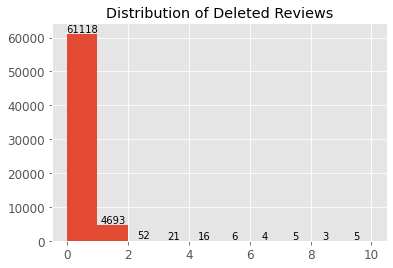

In [ ]:
deleted_reviews_size_df = total_deleted_reviews_df.groupby('total_deleted_reviews').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)

plt.style.use('ggplot')
plt.hist(total_deleted_reviews_df['total_deleted_reviews'], bins=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Deleted Reviews")

rects = ax.patches

# Make some labels.
labels = list(deleted_reviews_size_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_deletedreviews_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_deletedreviews_feature.csv',encoding='utf-8')
else:
    final_profiles_df = pd.merge(final_profiles_df,total_deleted_reviews_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df['total_deleted_reviews'] = final_profiles_df['total_deleted_reviews'].fillna(value=0)

    final_profiles_df['proportion_deleted_reviews'] = final_profiles_df['total_deleted_reviews'] / final_profiles_df['reviews_posted']

    final_profiles_df.to_csv('profiles/final_profiles_deletedreviews_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class,reviews_posted,total_deleted_reviews,proportion_deleted_reviews
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,1.0,0.5
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater,2.0,0.0,0.0
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist,11.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater,3.0,0.0,0.0


##### 2.4.3 Check for single-day reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/reviews_posted_by_profiles/final_reviews_posted_by_profiles_singledayeviews_feature.csv'):
    merged_reviews_df = pd.read_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_singledayeviews_feature.csv',encoding='utf-8')
else:
    timestamps = list(merged_reviews_df['sortTimestamp'])
    new_timestamps = [0 if math.isnan(timestamp) else timestamp for timestamp in timestamps]
    average_timestamp = sum(new_timestamps) / len(new_timestamps)
    average_timestamp_length = len(str(average_timestamp))
    merged_reviews_df['sortTimestamp'] = merged_reviews_df['sortTimestamp'].fillna(value=average_timestamp)
    merged_reviews_df['sortTimestamp'] = merged_reviews_df['sortTimestamp'].astype(str)
    merged_reviews_df['timestamp_length'] = merged_reviews_df['sortTimestamp'].str.len()
    merged_reviews_df['sortTimestamp'] = merged_reviews_df['sortTimestamp'].astype(float)
    merged_reviews_df.loc[merged_reviews_df.timestamp_length < average_timestamp_length, "sortTimestamp"] += merged_reviews_df.loc[merged_reviews_df.timestamp_length < average_timestamp_length, "sortTimestamp"] + average_timestamp

    merged_reviews_df['new_timestamp'] = pd.to_datetime(merged_reviews_df['sortTimestamp'],errors='coerce', format='%Y%m%d')

    merged_reviews_df.to_csv('reviews_posted_by_profiles/final_reviews_posted_by_profiles_singledayeviews_feature.csv',index=False,encoding='utf-8')

display(merged_reviews_df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acc_num,name,sortTimestamp,rating,helpfulVotes,asin,status,reviewCount,decoded_comment,cleaned_text,clean_product_name,word_count,brand_fuzzy_score,Matched_brand,probability_brand,loreal_review,verifiedPurchase,clean_title,clean_voting,dataset,sample_review,incentivized_text_score,incentivized_text,not_incentivized_texts_score,probability_incentivized_text,incentivized_review,deleted_review,timestamp_length,new_timestamp
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,1.360413e+12,0.0,0.0,NaN,Existing,0.0,NaN,NaN,NaN,0.0,44.0,others,0.758621,0,0.0,NaN,NaN,profile_reviews,0,0,NaN,102,0.000000,0,0,18,NaN
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,4.404650e+12,5.0,0.0,B001IAINFU,Existing,5343.0,works great! no smudge and comes off easy. it...,work great smudge come easy make lashed long d...,loreal paris makeup double extend beauty tube ...,17.0,100.0,loreal,50.000000,1,1.0,NaN,NaN,profile_reviews,0,31,NaN,71,0.436620,0,0,15,NaN
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,4.362128e+12,5.0,0.0,B01DBKRWWY,Existing,4661.0,i am elderly with very thin and fragil skin an...,elderly thin fragil skin preferred choice,quilted northern ultra plush toilet paper 12 d...,15.0,21.0,others,0.259259,0,1.0,NaN,NaN,profile_reviews,0,36,NaN,66,0.545455,0,0,15,NaN
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,4.362127e+12,5.0,0.0,B00DP64BN8,Existing,5969.0,this book was so enjoyable for me. after suff...,book wa enjoyable suffer severe concussion wa ...,nora robert land dare valley series book 1,159.0,32.0,others,0.457143,0,1.0,NaN,NaN,profile_reviews,0,15,NaN,87,0.172414,0,0,15,NaN
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,4.362123e+12,1.0,0.0,B06WVBTT2D,Existing,57.0,this opener will not operate on the types of c...,opener operate type purchase caution wa purcha...,electric opener sokos smooth soft edge electri...,113.0,22.0,others,0.275000,0,1.0,NaN,NaN,profile_reviews,0,22,NaN,80,0.275000,0,0,15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616268,NaN,NaN,1.360413e+12,0.8,NaN,B0047ENUXE,NaN,NaN,everlasting plum is my favorite shade. very pi...,everlasting plum favorite shade pigmented matt...,paris infallible le rouge lipstick always apri...,37.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,30,NaN,72,0.416667,0,0,18,NaN
616269,NaN,NaN,1.360413e+12,1.0,NaN,B0047ENUXE,NaN,NaN,i got this for 564 i mean this is a steal for ...,get 564 mean steal price rambling rise beautif...,paris infallible le rouge lipstick always apri...,40.0,NaN,loreal,1.000000,1,1.0,NaN,1.0,reviews,0,35,NaN,67,0.522388,0,0,18,NaN
616270,NaN,NaN,1.360413e+12,0.8,NaN,B0047ENUXE,NaN,NaN,i love the color absolutely. it brightens up t...,love color absolutely brighten face immediatel...,paris infallible le rouge lipstick always apri...,151.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,31,NaN,71,0.436620,0,0,18,NaN
616271,NaN,NaN,1.360413e+12,1.0,NaN,B0047ENUXE,NaN,NaN,very nice shade to give you pink lips..quality...,nice shade give pink lipstick shine moisture g...,paris infallible le rouge lipstick always apri...,28.0,NaN,loreal,1.000000,1,1.0,NaN,0.0,reviews,0,21,NaN,81,0.259259,0,0,18,NaN


In [ ]:
timestamp_df = merged_reviews_df.groupby(['acc_num','new_timestamp']).size().reset_index(name='count')
display(timestamp_df[timestamp_df['count'] > 1])

,acc_num,new_timestamp,count


##### 2.4.4 Check for Verified Purchase

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_verifiedpurchasereviews_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_verifiedpurchasereviews_feature.csv',encoding='utf-8')
else:
    verified_purchase_df = merged_reviews_df[merged_reviews_df['verifiedPurchase'] == 1].groupby('acc_num').size().reset_index(name='total_verified_reviews')

    final_profiles_df = pd.merge(final_profiles_df,verified_purchase_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df['total_verified_reviews'] = final_profiles_df['total_verified_reviews'].fillna(value=0)
    final_profiles_df['proportion_verified_reviews'] = final_profiles_df['total_verified_reviews'] / final_profiles_df['reviews_posted']

    final_profiles_df.to_csv('profiles/final_profiles_verifiedpurchasereviews_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class,reviews_posted,total_deleted_reviews,proportion_deleted_reviews,total_verified_reviews,proportion_verified_reviews
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,1.0,0.5,1.0,0.500000
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater,2.0,0.0,0.0,2.0,1.000000
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,10.0,0.909091
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,8.0,0.727273
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist,11.0,0.0,0.0,11.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater,3.0,0.0,0.0,2.0,0.666667


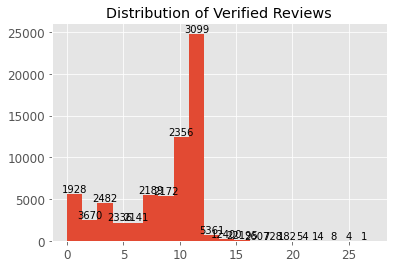

In [ ]:
total_verified_reviews_size_df = final_profiles_df.groupby('total_verified_reviews').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)

plt.style.use('ggplot')
plt.hist(final_profiles_df['total_verified_reviews'], bins=min(len(total_verified_reviews_size_df),20))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Verified Reviews")

rects = ax.patches

# Make some labels.
labels = list(total_verified_reviews_size_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

##### 2.4.5 Assign Suspicious Reviewers Class



1. **Never-Verified Reviewers**: These reviewers have never written a verified purchaser review. This raises a red flag because typical unbiased reviewers will review products after they purchased them. If a reviewer purchases a product from one retailer it would be odd to always write the review in different reviewing platform. This may indicate that the reviewer is not a legitimate account but rather a sockpuppet account set up by brands in order to post favorable reviews.

2.  **One-Hit Wonders**: These are reviewers who have written one review, which means these reviewers have only reviewed the product being analyzed. Unbiased reviewers tend to be long term members of a site who post more than a single one-off review. If a given product has a high percentage of One-Hit Wonders it can indicate that there is review manipulation occurring.  While there are a number of causes might result in a One-Hit Wonder, a few common ones include: brands creating throwaway accounts to a post single fake review for their product, or brands somehow enticing people who don’t normally write reviews to review this product. 

3.   **Take-Back Reviewers**: Any reviewer who we have discovered to have a deleted review in their history is flagged as a Take-Back Reviewer.  These reviewers are suspicious because the review was most likely removed by the review platform due to a violation of the terms of service. This may indicate that the user has been caught for review manipulation before and we don’t know for sure if they have stopped breaking the rules.

4.    **Single-Day Reviewers**: Reviewers who have posted multiple reviews but have posted all of them in a single day are labeled as Single-Day Reviewers. Like One-Hit Wonders, these reviewers lose trust because they haven’t shown a long term commitment to the reviewing platform. This lack of long term commitment may be indicative that the reviewer is posting biased reviews.  





In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_suspiciousreviewers_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_suspiciousreviewers_feature.csv',encoding='utf-8')
else:
    final_profiles_df['never_verified_reviewer'] = 0
    final_profiles_df.loc[(final_profiles_df['total_verified_reviews'] == 0) & (final_profiles_df['status'] == 'Existing'),"never_verified_reviewer"] = 1   

    final_profiles_df['one_hit_wonder'] = 0
    final_profiles_df.loc[(final_profiles_df['reviews_posted'] == 1) & (final_profiles_df['status'] == 'Existing'),"one_hit_wonder"] = 1

    final_profiles_df['take_back_reviewer'] = 0
    final_profiles_df.loc[(final_profiles_df['total_deleted_reviews'] > 0) & (final_profiles_df['status'] == 'Existing'),"take_back_reviewer"] = 1

    final_profiles_df.to_csv('profiles/final_profiles_suspiciousreviewers_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class,reviews_posted,total_deleted_reviews,proportion_deleted_reviews,total_verified_reviews,proportion_verified_reviews,never_verified_reviewer,one_hit_wonder,take_back_reviewer
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,1.0,0.5,1.0,0.500000,0,0,1
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater,2.0,0.0,0.0,2.0,1.000000,0,0,0
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,10.0,0.909091,0,0,0
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,8.0,0.727273,0,0,0
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist,11.0,0.0,0.0,11.0,1.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater,3.0,0.0,0.0,2.0,0.666667,0,0,0


,never_verified_reviewer,count
0,0,64014
1,1,1916


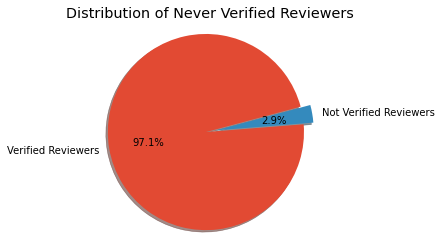

In [ ]:
never_verified_reviewers_df = final_profiles_df.groupby('never_verified_reviewer').size().reset_index(name='count')
display(never_verified_reviewers_df)

my_explode = (0, 0.1)
plt.pie(list(never_verified_reviewers_df['count']),labels=['Verified Reviewers','Not Verified Reviewers'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of Never Verified Reviewers')
plt.axis('equal')
plt.show()

,never_verified_reviewer,count
0,0,64014
1,1,1916


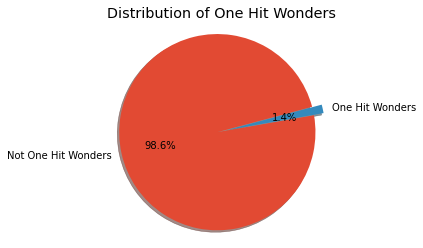

In [ ]:
one_hit_wonder_df = final_profiles_df.groupby('one_hit_wonder').size().reset_index(name='count')
display(never_verified_reviewers_df)

my_explode = (0, 0.1)
plt.pie(list(one_hit_wonder_df['count']),labels=['Not One Hit Wonders','One Hit Wonders'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of One Hit Wonders')
plt.axis('equal')
plt.show()

,never_verified_reviewer,count
0,0,64014
1,1,1916


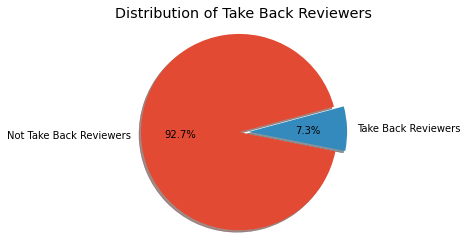

In [ ]:
take_back_reviewer_df = final_profiles_df.groupby('take_back_reviewer').size().reset_index(name='count')
display(never_verified_reviewers_df)

my_explode = (0, 0.1)
plt.pie(list(take_back_reviewer_df['count']),labels=['Not Take Back Reviewers','Take Back Reviewers'],autopct='%1.1f%%',startangle=15, shadow = True, explode=my_explode)
plt.title('Distribution of Take Back Reviewers')
plt.axis('equal')
plt.show()

#### 2.5 Overlapping History

In [ ]:
# network_df = merged_reviews_df.copy()
# network_df = network_df.groupby(['acc_num','asin']).size().reset_index(name='frequency')
# network_df.columns = ['reviewer','product','frequency']

# network_df.dropna(subset=['product'],inplace=True)
# print(len(network_df))
# display(network_df)

In [ ]:
# history_graph = nx.from_pandas_edgelist(network_df, source='reviewer', target='product',edge_attr='frequency',\
#                                         create_using=nx.DiGraph()) 

In [ ]:
# if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_network_feature.csv'):
#     high_degree_products_df = pd.read_csv('profiles/final_profiles_network_feature.csv',encoding='utf-8')
# else:
#     start_time = time.time()

#     unique_products = list(network_df['product'].unique())

#     high_degree_products = [node for node in history_graph.nodes() if node in unique_products and history_graph.degree(node) > 1]

#     print("Identified High Degree Products: %s seconds" % (time.time() - start_time))
#     print("Number of Products which has overlapping history: {}/{} ({}%)\n".format(len(high_degree_products),\
#                                                                                 len(unique_products),\
#                                                                                 len(high_degree_products)/len(unique_products)*100))

#     start_time = time.time()

#     high_degree_products_degrees = [history_graph.degree(node) for node in history_graph.nodes() if node in high_degree_products]

#     print("Retrieved Degrees for High Degree Products: %s seconds\n" % (time.time() - start_time))
#     high_degree_products_df = pd.DataFrame(high_degree_products, columns =['product'])
#     high_degree_products_df['degrees'] = high_degree_products_degrees

#     high_degree_products_df.to_csv('profiles/final_profiles_network_feature.csv',index=False,encoding='utf-8')

# display(high_degree_products_df)

In [ ]:
# high_degree_products_df = high_degree_products_df.sort_values(by=['degrees'],ascending=False)
# top_nine_products_df = high_degree_products_df[:9]
# display(top_nine_products_df)

In [ ]:
# plt.figure(figsize=(12, 12))

# start_time = time.time()

# # 2. Create a layout for our nodes 
# layout = nx.spring_layout(history_graph,iterations=10)

# print("Network Layout Completed! Time taken: %s seconds\n" % (time.time() - start_time))

# # 3. Draw the parts we want
# nx.draw_networkx_edges(history_graph, layout, edge_color='#AAAAAA')

# products = [node for node in history_graph.nodes() if node in network_df.product.unique()]
# size = [history_graph.degree(node) * 50 for node in history_graph.nodes() if node in network_df.product.unique()]
# nx.draw_networkx_nodes(history_graph, layout, nodelist=clubs, node_size=size, node_color='lightblue')

# profiles = [node for node in history_graph.nodes() if node in network_df.reviewer.unique()]
# nx.draw_networkx_nodes(history_graph, layout, nodelist=profiles, node_size=100, node_color='#AAAAAA')

# high_degree_products = [node for node in history_graph.nodes() if node in history_graph.product.unique() and history_graph.degree(node) > 1]
# nx.draw_networkx_nodes(history_graph, layout, nodelist=high_degree_products, node_size=100, node_color='#fc8d62')

# product_dict = dict(zip(products, products))
# nx.draw_networkx_labels(history_graph, layout, labels=product_dict)

# # 4. Turn off the axis because I know you don't want it
# plt.axis('off')

# plt.title("Review History")

# # 5. Tell matplotlib to show it
# plt.show()

#### 2.6 Word Count

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/profiles/final_profiles_reviewlength_feature.csv'):
    final_profiles_df = pd.read_csv('profiles/final_profiles_reviewlength_feature.csv',encoding='utf-8')
else:
    merged_reviews_df['review_length'] = merged_reviews_df['decoded_comment'].str.len()
    merged_reviews_df['review_length'] = merged_reviews_df['review_length'].fillna(value=0)

    review_length_df = merged_reviews_df.groupby('acc_num').agg({'review_length':np.mean}).reset_index()
    review_length_df = review_length_df.rename(columns={'review_length':'average_review_length'})

    final_profiles_df = pd.merge(final_profiles_df,review_length_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df['average_review_length'] = final_profiles_df['average_review_length'].fillna(value=0)

    total_review_length = merged_reviews_df['review_length'].sum()
    final_profiles_df['standardized_average_review_length'] = final_profiles_df['average_review_length'] / total_review_length
    
    final_profiles_df.to_csv('profiles/final_profiles_reviewlength_feature.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviewer_ease_score,total_loreal_reviews,proportion_loreal_reviews,total_products,total_loreal_products,proportion_brand_products,brand_repeat_class,reviews_posted,total_deleted_reviews,proportion_deleted_reviews,total_verified_reviews,proportion_verified_reviews,never_verified_reviewer,one_hit_wonder,take_back_reviewer,average_review_length,standardized_average_review_length
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,1.0,0.5,1.0,0.500000,0,0,1,31.500000,2.753072e-07
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.000000,2.0,2.0,1.0,1.0,1.000000,Brand Repeater,2.0,0.0,0.0,2.0,1.000000,0,0,0,90.000000,7.865919e-07
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,0.854545,1.0,0.1,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,10.0,0.909091,0,0,0,545.454545,4.767223e-06
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,0.727273,2.0,0.2,2.0,1.0,0.500000,Brand Loyalist,11.0,0.0,0.0,8.0,0.727273,0,0,0,205.818182,1.798832e-06
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,0.981818,2.0,0.2,3.0,2.0,0.666667,Brand Loyalist,11.0,0.0,0.0,11.0,1.000000,0,0,0,223.909091,1.956945e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0,6.000000,5.243946e-08
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.400000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0,65.000000,5.680941e-07
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.500000,1.0,1.0,2.0,1.0,0.500000,Brand Repeater,2.0,0.0,0.0,1.0,0.500000,0,0,0,152.000000,1.328466e-06
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,2.0,2.0,2.0,1.0,0.500000,Brand Repeater,3.0,0.0,0.0,2.0,0.666667,0,0,0,54.666667,4.777817e-07


### 3. Product

##### 3.1 Products Metadata

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products.csv'):
    products_df = pd.read_csv('products/final_products.csv',encoding='utf-8')
else:
    products_df = final_reviews_df.groupby(['asin','clean_product_name']).size().reset_index(name='count')

    products_df.to_csv('products/final_products.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363
1,B00005333G,face moisturizer loreal paris skin care moistu...,407
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560
...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247


##### 3.2 Word Count

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_reviewlength_feature.csv'):
    products_df = pd.read_csv('products/final_products_reviewlength_feature.csv',encoding='utf-8')
else:
    merged_reviews_df['review_length'] = merged_reviews_df['decoded_comment'].str.len()
    average_review_length = sum(list(merged_reviews_df['review_length'])) / len(list(merged_reviews_df['review_length']))
    merged_reviews_df['review_length'] = merged_reviews_df['review_length'].fillna(value=average_review_length)

    product_review_length_df = merged_reviews_df.groupby('asin').agg({'review_length':np.mean}).reset_index()
    product_review_length_df = product_review_length_df.rename(columns={'review_length':'average_review_length'})

    products_df = pd.merge(products_df,product_review_length_df,left_on=['asin'], right_on = ['asin'], how = 'left')

    total_review_length = products_df['average_review_length'].sum()
    products_df['standardized_average_review_length'] = products_df['average_review_length'] / total_review_length

    products_df.to_csv('products/final_products_reviewlength_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591
...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789


#### 3.3 Ratings

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_ratings_feature.csv'):
    products_df = pd.read_csv('products/final_products_ratings_feature.csv',encoding='utf-8')
else:
    merged_reviews_df.loc[merged_reviews_df['dataset'] == 'profile_reviews', "rating"] /= max(merged_reviews_df[merged_reviews_df['dataset'] == 'profile_reviews']['rating'])
    merged_reviews_df[merged_reviews_df['dataset'] == 'profile_reviews']['rating']

    average_ratings = sum(list(merged_reviews_df['rating'])) / len(list(merged_reviews_df['rating']))
    merged_reviews_df['rating'] = merged_reviews_df['rating'].fillna(value=average_ratings)
    average_rating_df = merged_reviews_df.groupby('asin').agg({'rating':np.mean}).reset_index()
    average_rating_df = average_rating_df.rename(columns={'rating':'average_rating'})

    products_df = pd.merge(products_df,average_rating_df,left_on=['asin'], right_on = ['asin'], how = 'left')

    products_df.to_csv('products/final_products_ratings_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length,average_rating
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059,0.807692
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020,0.786024
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705,0.773333
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735,0.820423
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591,0.803460
...,...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775,0.787713
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517,0.815162
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415,0.786276
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789,0.829032


#### 3.4 Distribution of Brand Repeats

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_brandrepeats_feature.csv'):
    products_df = pd.read_csv('products/final_products_brandrepeats_feature.csv',encoding='utf-8')
else:
    merged_reviews_df = pd.merge(merged_reviews_df,final_profiles_df[['acc_num','brand_repeat_class']],left_on=['acc_num'], right_on = ['acc_num'], how = 'left')

    product_brand_repeats_df = merged_reviews_df.groupby(['asin','brand_repeat_class']).size().reset_index(name='count')

    total_product_brand_repeats_df = product_brand_repeats_df.groupby('asin').sum().reset_index()
    total_product_brand_repeats_df = total_product_brand_repeats_df.rename(columns={'count':'total'})

    product_brand_repeats_df = pd.merge(product_brand_repeats_df,total_product_brand_repeats_df,left_on=['asin'], right_on = ['asin'], how = 'left')
    product_brand_repeats_df['proportion_brand_repeats'] = product_brand_repeats_df['count'] / product_brand_repeats_df['total']


    new_brand_repeats_columns = ['proportion_brand_repeaters','proportion_brand_loyalists',\
                                'proportion_brand_monogamists','proportion_brand_others']

    for column in new_brand_repeats_columns:
        products_df[column] = 0

    for index,row in product_brand_repeats_df.iterrows():
        if row['brand_repeat_class'] == 'Brand Repeater':
            products_df.loc[products_df['asin'] == row['asin'], "proportion_brand_repeaters"] = row['proportion_brand_repeats']
        elif row['brand_repeat_class'] == 'Brand Loyalist':
            products_df.loc[products_df['asin'] == row['asin'], "proportion_brand_loyalists"] = row['proportion_brand_repeats']
        elif row['brand_repeat_class'] == 'Brand Monogamist':
            products_df.loc[products_df['asin'] == row['asin'], "proportion_brand_monogamists"] = row['proportion_brand_repeats']
        else:
            products_df.loc[products_df['asin'] == row['asin'], "proportion_brand_others"] = row['proportion_brand_repeats']
 
    products_df.to_csv('products/final_products_brandrepeats_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length,average_rating,proportion_brand_repeaters,proportion_brand_loyalists,proportion_brand_monogamists,proportion_brand_others
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059,0.807692,0.086111,0.913889,0.0,0.000000
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020,0.786024,0.101205,0.898795,0.0,0.000000
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705,0.773333,0.045833,0.954167,0.0,0.000000
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735,0.820423,0.035211,0.714789,0.0,0.250000
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591,0.803460,0.069204,0.929066,0.0,0.001730
...,...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775,0.787713,0.118881,0.874126,0.0,0.006993
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517,0.815162,0.098013,0.899338,0.0,0.002649
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415,0.786276,0.091571,0.906348,0.0,0.002081
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789,0.829032,0.088983,0.894068,0.0,0.016949


#### 3.5 Distribution of Deleted Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_deletedreviews_feature.csv'):
    products_df = pd.read_csv('products/final_products_deletedreviews_feature.csv',encoding='utf-8')
else:
    product_deletedreviews_df = merged_reviews_df.groupby('asin').agg({'deleted_review':sum}).reset_index()
    product_deletedreviews_df = product_deletedreviews_df.rename(columns={'deleted_review':'total_deleted_review'})

    products_df = pd.merge(products_df,product_deletedreviews_df,left_on=['asin'], right_on = ['asin'], how = 'left')
    products_df['proportion_deleted_reviews'] = products_df['total_deleted_review'] / products_df['count']
 
    products_df.to_csv('products/final_products_deletedreviews_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length,average_rating,proportion_brand_repeaters,proportion_brand_loyalists,proportion_brand_monogamists,proportion_brand_others,total_deleted_review,proportion_deleted_reviews
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059,0.807692,0.086111,0.913889,0.0,0.000000,0,0.0
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020,0.786024,0.101205,0.898795,0.0,0.000000,0,0.0
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705,0.773333,0.045833,0.954167,0.0,0.000000,0,0.0
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735,0.820423,0.035211,0.714789,0.0,0.250000,0,0.0
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591,0.803460,0.069204,0.929066,0.0,0.001730,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775,0.787713,0.118881,0.874126,0.0,0.006993,0,0.0
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517,0.815162,0.098013,0.899338,0.0,0.002649,0,0.0
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415,0.786276,0.091571,0.906348,0.0,0.002081,0,0.0
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789,0.829032,0.088983,0.894068,0.0,0.016949,0,0.0


#### 3.6 Distribution of Verified Purchase

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_verifiedreviews_feature.csv'):
    products_df = pd.read_csv('products/final_products_verifiedreviews_feature.csv',encoding='utf-8')
else:
    product_verifiedpurchase_df = merged_reviews_df.groupby('asin').agg({'verifiedPurchase':sum}).reset_index()
    product_verifiedpurchase_df = product_verifiedpurchase_df.rename(columns={'verifiedPurchase':'total_verified_review'})

    products_df = pd.merge(products_df,product_verifiedpurchase_df,left_on=['asin'], right_on = ['asin'], how = 'left')
    products_df['proportion_verified_reviews'] = products_df['total_verified_review'] / products_df['count']
 
    products_df.to_csv('products/final_products_verifiedreviews_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length,average_rating,proportion_brand_repeaters,proportion_brand_loyalists,proportion_brand_monogamists,proportion_brand_others,total_deleted_review,proportion_deleted_reviews,total_verified_review,proportion_verified_reviews
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059,0.807692,0.086111,0.913889,0.0,0.000000,0,0.0,352.0,0.969697
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020,0.786024,0.101205,0.898795,0.0,0.000000,0,0.0,364.0,0.894349
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705,0.773333,0.045833,0.954167,0.0,0.000000,0,0.0,422.0,0.907527
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735,0.820423,0.035211,0.714789,0.0,0.250000,0,0.0,256.0,0.924188
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591,0.803460,0.069204,0.929066,0.0,0.001730,0,0.0,521.0,0.930357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775,0.787713,0.118881,0.874126,0.0,0.006993,0,0.0,255.0,0.870307
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517,0.815162,0.098013,0.899338,0.0,0.002649,0,0.0,684.0,0.823105
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415,0.786276,0.091571,0.906348,0.0,0.002081,0,0.0,861.0,0.868819
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789,0.829032,0.088983,0.894068,0.0,0.016949,0,0.0,138.0,0.558704


#### 3.7 Distribution of Suspicious Reviewers

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/feature_engineering/products/final_products_suspiciousreviewers_feature.csv'):
    products_df = pd.read_csv('products/final_products_suspiciousreviewers_feature.csv',encoding='utf-8')
else:
    reviews_suspiciousreviewers_df = pd.merge(merged_reviews_df,final_profiles_df[['acc_num','never_verified_reviewer','one_hit_wonder','take_back_reviewer']],left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    product_suspiciousreviewers_df = reviews_suspiciousreviewers_df.groupby('asin').agg({'never_verified_reviewer':sum,'one_hit_wonder':sum,'take_back_reviewer':sum}).reset_index()
    product_suspiciousreviewers_df = product_suspiciousreviewers_df.rename(columns={'never_verified_reviewer':'total_never_verified_reviewer',\
                                                                            'one_hit_wonder':'total_one_hit_wonder',\
                                                                            'take_back_reviewer':'total_take_back_reviewer'})

    products_df = pd.merge(products_df,product_suspiciousreviewers_df,left_on=['asin'], right_on = ['asin'], how = 'left')
    products_df['proportion_never_verified_reviewer'] = products_df['total_never_verified_reviewer'] / products_df['count']
    products_df['proportion_one_hit_wonder'] = products_df['total_one_hit_wonder'] / products_df['count']
    products_df['proportion_take_back_reviewer'] = products_df['total_take_back_reviewer'] / products_df['count']
 
    products_df.to_csv('products/final_products_suspiciousreviewers_feature.csv',index=False,encoding='utf-8')

display(products_df)

,asin,clean_product_name,count,average_review_length,standardized_average_review_length,average_rating,proportion_brand_repeaters,proportion_brand_loyalists,proportion_brand_monogamists,proportion_brand_others,total_deleted_review,proportion_deleted_reviews,total_verified_review,proportion_verified_reviews,total_never_verified_reviewer,total_one_hit_wonder,total_take_back_reviewer,proportion_never_verified_reviewer,proportion_one_hit_wonder,proportion_take_back_reviewer
0,B0000531SW,loreal paris visible lift makeup soft ivory ounce,363,150.887363,0.007059,0.807692,0.086111,0.913889,0.0,0.000000,0,0.0,352.0,0.969697,2.0,0.0,20.0,0.005510,0.000000,0.055096
1,B00005333G,face moisturizer loreal paris skin care moistu...,407,214.175904,0.010020,0.786024,0.101205,0.898795,0.0,0.000000,0,0.0,364.0,0.894349,6.0,12.0,31.0,0.014742,0.029484,0.076167
2,B00005333I,eye cream reduce puffiness line dark circle lo...,465,186.072917,0.008705,0.773333,0.045833,0.954167,0.0,0.000000,0,0.0,422.0,0.907527,6.0,7.0,19.0,0.012903,0.015054,0.040860
3,B000KOLX7U,paris revitalift firm day cream spf 25 sunscre...,277,143.947183,0.006735,0.820423,0.035211,0.714789,0.0,0.250000,0,0.0,256.0,0.924188,3.0,4.0,11.0,0.010830,0.014440,0.039711
4,B000KOLXKM,eye cream professional retinol loreal paris sk...,560,162.250865,0.007591,0.803460,0.069204,0.929066,0.0,0.001730,0,0.0,521.0,0.930357,15.0,9.0,42.0,0.026786,0.016071,0.075000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,glycolic acid peel serum skin loreal paris rev...,293,187.563140,0.008775,0.787713,0.118881,0.874126,0.0,0.006993,0,0.0,255.0,0.870307,22.0,0.0,33.0,0.075085,0.000000,0.112628
103,B07X82S53H,loreal paris makeup infallible 24 hour fresh w...,831,267.551143,0.012517,0.815162,0.098013,0.899338,0.0,0.002649,0,0.0,684.0,0.823105,62.0,0.0,72.0,0.074609,0.000000,0.086643
104,B07YGB5SPC,hyaluronic acid serum skin loreal paris skinca...,991,179.871847,0.008415,0.786276,0.091571,0.906348,0.0,0.002081,0,0.0,861.0,0.868819,50.0,0.0,77.0,0.050454,0.000000,0.077699
105,B07Z9WFWZ8,loreal paris age perfect radiant serum foundat...,247,337.471774,0.015789,0.829032,0.088983,0.894068,0.0,0.016949,0,0.0,138.0,0.558704,68.0,0.0,26.0,0.275304,0.000000,0.105263


### 4. Save final dataset for modelling

#### 4.1 Merge Engineered Features to Original Reviews

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/usecase2/final_feature_engineering.csv'):
    final_reviews_features_df = pd.read_csv('final_feature_engineering.csv',encoding='utf-8')
else:
    print('1. Current Size of Reviews Dataset: {}'.format(len(final_reviews_df)))
    to_be_merged_reviews_df = final_reviews_df[['asin', 'clean_title', 'decoded_comment', 'rating', 'verifiedPurchase', 'acc_num', 'clean_voting', 'clean_product_name', 'cleaned_text','word_count', 'loreal_review']]
    to_be_merged_reviews_df.columns = ['asin', 'clean_title', 'decoded_comment', 'review_rating', 'review_verified_purchase', 'acc_num', 'review_voting', 'clean_product_name', 'cleaned_text','review_word_count', 'review_loreal_review']

    to_be_merged_features_reviews_df = merged_reviews_df[['acc_num','asin','decoded_comment','helpfulVotes','sample_review','incentivized_review','deleted_review']]
    to_be_merged_features_reviews_df.columns = ['acc_num','asin','decoded_comment','review_helpful_votes','review_sample','review_incentivized','review_deleted']
    final_reviews_features_df = pd.merge(to_be_merged_reviews_df,to_be_merged_features_reviews_df,left_on=['acc_num','asin','decoded_comment'], right_on = ['acc_num','asin','decoded_comment'], how = 'left')

    print('2. Current Size of Reviews Dataset: {}'.format(len(final_reviews_features_df)))
    product_features_df = products_df[['asin', 'count', 'average_review_length','standardized_average_review_length','average_rating', 'proportion_brand_repeaters','proportion_brand_loyalists', 'proportion_brand_monogamists','proportion_brand_others', 'total_deleted_review','proportion_deleted_reviews', 'total_verified_review','proportion_verified_reviews','total_one_hit_wonder', 'total_take_back_reviewer', 'proportion_one_hit_wonder','proportion_take_back_reviewer']]
    product_features_df.columns = ['asin', 'product_total_reviews', 'product_average_review_length','product_standardized_average_review_length','product_average_rating', 'product_proportion_brand_repeaters','product_proportion_brand_loyalists', 'product_proportion_brand_monogamists','product_proportion_brand_others', 'product_total_deleted_review','product_proportion_deleted_reviews', 'product_total_verified_review','product_proportion_verified_reviews','product_total_one_hit_wonder', 'product_total_take_back_reviewer', 'product_proportion_one_hit_wonder','product_proportion_take_back_reviewer']
    final_reviews_features_df = pd.merge(final_reviews_features_df,product_features_df, left_on=['asin'], right_on = ['asin'], how = 'left')

    print('3. Current Size of Reviews Dataset: {}'.format(len(final_reviews_features_df)))
    profile_features_df = final_profiles_df[['acc_num','badges', 'ranking', 'average_votes','average_reviewcount', 'average_wordcount', 'reviews_posted', 'reviewer_ease_score','total_loreal_reviews', 'proportion_loreal_reviews', 'total_products','total_loreal_products', 'proportion_brand_products','brand_repeat_class', 'total_deleted_reviews','proportion_deleted_reviews', 'total_verified_reviews','proportion_verified_reviews', 'never_verified_reviewer','one_hit_wonder', 'take_back_reviewer', 'average_review_length','standardized_average_review_length']]
    profile_features_df.columns = ['acc_num','profile_badges', 'profile_ranking', 'profile_average_votes','profile_average_reviewcount', 'profile_average_wordcount', 'profile_reviews_posted', 'profile_reviewer_ease_score','profile_total_loreal_reviews', 'profile_proportion_loreal_reviews', 'profile_total_products','profile_total_loreal_products', 'profile_proportion_loreal_products','profile_brand_repeat_class', 'profile_total_deleted_reviews','profile_proportion_deleted_reviews', 'profile_total_verified_reviews','profile_proportion_verified_reviews', 'profile_never_verified_reviewer','profile_one_hit_wonder', 'profile_take_back_reviewer', 'profile_average_review_length','profile_standardized_average_review_length']
    final_reviews_features_df = pd.merge(final_reviews_features_df,profile_features_df, left_on=['acc_num'], right_on = ['acc_num'], how = 'left')

    final_reviews_features_df = final_reviews_features_df.drop(columns=['decoded_comment'])
 
    final_reviews_features_df.to_csv('final_feature_engineering.csv',index=False,encoding='utf-8')

display(final_reviews_features_df)

1. Current Size of Reviews Dataset: 85097
2. Current Size of Reviews Dataset: 85097
3. Current Size of Reviews Dataset: 85097


,asin,clean_title,review_rating,review_verified_purchase,acc_num,review_voting,clean_product_name,cleaned_text,review_word_count,review_loreal_review,review_helpful_votes,review_sample,review_incentivized,review_deleted,product_total_reviews,product_average_review_length,product_standardized_average_review_length,product_average_rating,product_proportion_brand_repeaters,product_proportion_brand_loyalists,product_proportion_brand_monogamists,product_proportion_brand_others,product_total_deleted_review,product_proportion_deleted_reviews,product_total_verified_review,product_proportion_verified_reviews,product_total_one_hit_wonder,product_total_take_back_reviewer,product_proportion_one_hit_wonder,product_proportion_take_back_reviewer,profile_badges,profile_ranking,profile_average_votes,profile_average_reviewcount,profile_average_wordcount,profile_reviews_posted,profile_reviewer_ease_score,profile_total_loreal_reviews,profile_proportion_loreal_reviews,profile_total_products,profile_total_loreal_products,profile_proportion_brand_products,profile_brand_repeat_class,profile_total_deleted_reviews,profile_proportion_deleted_reviews,profile_total_verified_reviews,profile_proportion_verified_reviews,profile_never_verified_reviewer,profile_one_hit_wonder,profile_take_back_reviewer,profile_average_review_length,profile_standardized_average_review_length
0,B01M09QQI0,love love love,1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,face moisturizer l oreal paris skin care age p...,love love love moisturizer woman ha bless many...,101.0,1,NaN,0,0,0,1807,181.026616,0.008469,0.803150,0.049180,0.946136,0.0,0.004684,0,0.0,1621.0,0.897067,0.0,92.0,0.000000,0.050913,NaN,237158.0,0.3,732.5,174.0,13.0,0.953846,3.0,0.3,2.0,1.0,0.5,Brand Loyalist,0.0,0.0,13.0,1.0,0.0,0.0,0.0,834.615385,0.000007
1,B01M09QQI0,love it,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,face moisturizer l oreal paris skin care age p...,moisturizer work well skin let start say 37 ye...,142.0,1,NaN,0,0,0,1807,181.026616,0.008469,0.803150,0.049180,0.946136,0.0,0.004684,0,0.0,1621.0,0.897067,0.0,92.0,0.000000,0.050913,NaN,5335592.0,1.0,5135.8,64.2,13.0,0.830769,3.0,0.3,2.0,1.0,0.5,Brand Loyalist,0.0,0.0,13.0,1.0,0.0,0.0,0.0,395.076923,0.000003
2,B01M09QQI0,they say that i look younger!,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,face moisturizer l oreal paris skin care age p...,know sound good true maybe folk try nice wa te...,78.0,1,3.0,0,0,0,1807,181.026616,0.008469,0.803150,0.049180,0.946136,0.0,0.004684,0,0.0,1621.0,0.897067,0.0,92.0,0.000000,0.050913,NaN,469870.0,0.7,4772.7,40.9,11.0,0.945455,1.0,0.1,2.0,1.0,0.5,Brand Loyalist,0.0,0.0,11.0,1.0,0.0,0.0,0.0,228.000000,0.000002
3,B01M09QQI0,old,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,face moisturizer l oreal paris skin care age p...,first jar order smell wonderful go skin smooth...,76.0,1,6.0,0,0,0,1807,181.026616,0.008469,0.803150,0.049180,0.946136,0.0,0.004684,0,0.0,1621.0,0.897067,0.0,92.0,0.000000,0.050913,NaN,63277988.0,6.0,4300.0,76.0,2.0,0.200000,1.0,1.0,2.0,1.0,0.5,Brand Repeater,0.0,0.0,2.0,1.0,0.0,0.0,0.0,382.000000,0.000003
4,B01M09QQI0,does what it claims,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,face moisturizer l oreal paris skin care age p...,use product six week 62 daily moisturizer ha m...,131.0,1,NaN,0,0,0,1807,181.026616,0.008469,0.803150,0.049180,0.946136,0.0,0.004684,0,0.0,1621.0,0.897067,0.0,92.0,0.000000,0.050913,NaN,1498374.0,0.6,1405.9,46.2,12.0,0.683333,3.0,0.3,2.0,1.0,0.5,Brand Loyalist,0.0,0.0,12.0,1.0,0.0,0.0,0.0,313.500000,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,B0047ENUXE,NaN,0.8,1.0,NaN,0,paris infallible le rouge lipstick always apri...,everlasting plum favorite shade pigmented matt...,37.0,1,NaN,0,0,0,283,126.560284,0.005921,0.760284,0.089202,0.877934,0.0,0.032864,0,0.0,268.0,0.946996,1.0,16.0,0.003534,0.056537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N